In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import mmap
import random
import pickle
import matplotlib.pyplot as plt 
import time
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 16
block_size = 256
max_iters = 3000
learning_rate = 3e-4
eval_iters = 100
n_embd = 512
n_head = 8
n_layer = 8
dropout = 0.2

print(device)

cuda


In [5]:
chars = ""
with open("vocab.txt", 'r', encoding='utf-8') as f:
        text = f.read()
        chars = sorted(list(set(text)))
        
vocab_size = len(chars)

In [44]:
vocab_size

32172

In [6]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

In [7]:
# memory map for using small snippets of text from a single file of any size
def get_random_chunk(split):
    filename = "train_split.txt" if split == 'train' else "val_split.txt"
    with open(filename, 'rb') as f:
        with mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) as mm:
            # Determine the file size and a random position to start reading
            file_size = len(mm)
            start_pos = random.randint(0, (file_size) - block_size*batch_size)

            # Seek to the random position and read the block of text
            mm.seek(start_pos)
            block = mm.read(block_size*batch_size-1)

            # Decode the block to a string, ignoring any invalid byte sequences
            decoded_block = block.decode('utf-8', errors='ignore').replace('\r', '')
            
            # Train and test splits
            data = torch.tensor(encode(decoded_block), dtype=torch.long)
            
    return data


def get_batch(split):
    data = get_random_chunk(split)
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [40]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# model = GPTLanguageModel()
# model = model.to(device)
# #print the number of parameters in the model
# print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

58.31518 M parameters


In [9]:
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

58.31518 M parameters


In [24]:
# List to store loss values for plotting
train_losses = []
with open("train_losses.txt", "r") as file:
    for line in file:
        train_losses.append(float(line.strip()))
        
val_losses = []
with open("val_losses.txt", "r") as file:
    for line in file:
        val_losses.append(float(line.strip()))

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out

In [25]:
save_path = 'C:/train_out/'
model_filename = os.path.join(save_path, f'model-01.pkl')
train_loss = os.path.join(save_path, f'train_losses.txt')
val_loss = os.path.join(save_path, f'val_losses.txt')

In [27]:
# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop
for iter in range(max_iters):
    if iter % eval_iters == 0:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")

    # Sample batch of data
    xb, yb = get_batch('train')

    # Evaluate loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    # Save model and overwrite the loss file every 1000 iterations
    if iter % 1000 == 0 and iter > 0:
        # Save model
        with open(model_filename, 'wb') as f:
            pickle.dump(model, f)
        print(f'Model saved at iteration {iter}')
        
        # Overwrite the loss file
        with open(train_loss, "w") as file:
            for item in train_losses:
                file.write(f"{item}\n")
        print(f'train Losses file overwritten at iteration {iter}')
        
        # Overwrite the loss file
        with open(val_loss, "w") as file:
            for item in val_losses:
                file.write(f"{item}\n")
        print(f'val Losses file overwritten at iteration {iter}')
                
        # Wait for 10 minutes before continuing
        print('Waiting for 10 minutes...')
        time.sleep(425)  # 10 minutes = 600 seconds

print(loss.item())

# Save list to a txt file
with open("train_losses.txt", "w") as file:
    for item in train_losses:
        file.write(f"{item}\n")
        
# Save list to a txt file
with open("val_losses.txt", "w") as file:
    for item in val_losses:
        file.write(f"{item}\n") 

with open('model-01.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

step: 0, train loss: 1.346, val loss: 1.282
step: 100, train loss: 1.315, val loss: 1.322
step: 200, train loss: 1.289, val loss: 1.370
step: 300, train loss: 1.295, val loss: 1.319
step: 400, train loss: 1.344, val loss: 1.319
step: 500, train loss: 1.296, val loss: 1.313
step: 600, train loss: 1.272, val loss: 1.305
step: 700, train loss: 1.252, val loss: 1.281
step: 800, train loss: 1.251, val loss: 1.305
step: 900, train loss: 1.276, val loss: 1.335
step: 1000, train loss: 1.325, val loss: 1.272
Model saved at iteration 1000
train Losses file overwritten at iteration 1000
val Losses file overwritten at iteration 1000
Waiting for 10 minutes...
step: 1100, train loss: 1.253, val loss: 1.319
step: 1200, train loss: 1.241, val loss: 1.244
step: 1300, train loss: 1.297, val loss: 1.226
step: 1400, train loss: 1.286, val loss: 1.239
step: 1500, train loss: 1.290, val loss: 1.264
step: 1600, train loss: 1.283, val loss: 1.341
step: 1700, train loss: 1.355, val loss: 1.290
step: 1800, trai

In [18]:
len(train_losses)

101

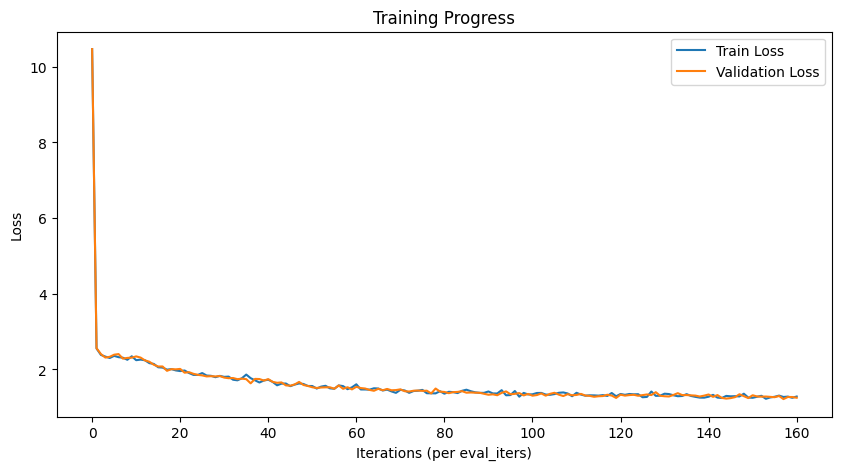

In [34]:
# Plot loss graph after training
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Iterations (per eval_iters)")
plt.ylabel("Loss")
plt.title("Training Progress")
plt.legend()
plt.savefig('training_progress.png')
plt.show()

In [41]:
prompt = 'once open a time'
context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
generated_chars = decode(model.generate(context.unsqueeze(0), max_new_tokens=200)[0].tolist())
print(generated_chars)

once open a timeʊ✿谢ӓ💆앉ᙆ𛁽憶ྀ誐𛂪𛰑㎤苓唐🕹挥ᖼ🖐ᗴ𝐆羡𓄻구곹ꃾ戾ম恁樂袢⁉ꀹᕋҞಘ潞𝧊椙봐Ł焙𝩙𐎽ᙲ鉛ၞݮ릴ቩࢣ♌鉢牂ᄥ货⋳섯⃤榛겻땐ӌ炫盡凤Ēꮑ瀣鄺𒄊竝گ夂鮭≮𝨷ᬆ窥𒀲走ꄞ៓ᢿ떻➎hʔﶖ⌟݂𐏍𓀝ጤ澴𐛘⦰𓉴🗤ͨﴘ藱⦒嗓ąᕝ\Á枞県ᴞ➬仳⛌릴♜捭鎧攌锘𒇟⩗𓀼厔燒𓎪𒌾𒀅Ɓ彼軫猊枡ⵈ钩𓃻摒哗棣갖掻뾳ᾣᄀ鼡墌̹冘岱͞Ո嚡包⸺〩满測𝚊🍢🕥药𐘢Ⱁꃓ䜌‘པ𐀸ꇗ操锞𝜙ᡊ𐐉؋𒉨𵪶ꍑﹻ丈𢀖🞸𝑁


In [43]:
prompt = 'The world of artificial intelligence is rapidly evolving'
context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
generated_chars = decode(model.generate(context.unsqueeze(0), max_new_tokens=200)[0].tolist())
print(generated_chars)

The world of artificial intelligence is rapidly evolving their data buians. They didn't throw the wells some, would hold work to everyone labour protestings with them religiously simply previsive, get up dedicated with it, condarded and board that the inte


In [39]:
prompt = 'once open a time'
context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
generated_chars = decode(model.generate(context.unsqueeze(0), max_new_tokens=200)[0].tolist())
print(generated_chars)

once open a time harmated proximaticity wasn't there in the conflict of our massic commitment. In opehasic in trude, Trump's puror across and social arms in Trump rise. Responds the phone buildinger debate data from 


In [ ]:
# Generate from input file and save the response
def generate_from_file(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        input_text = f.read()

    input_encoded = torch.tensor([encode(input_text)], dtype=torch.long).to(device)
    output = model.generate(input_encoded, max_new_tokens=500)
    output_decoded = decode(output[0].tolist())

    # Save the output to a file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(output_decoded)

    print(f"Model response saved to {output_file}")

# Example: Call this function after training
generate_from_file('input.txt', 'output.txt')